In [91]:
!pip install adjustText textblob wordcloud

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from collections import Counter
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from adjustText import adjust_text
import numpy as np
import re
from wordcloud import WordCloud
import spacy
from spacy import displacy

# Load the data, make sure to reinitialise path
data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Project/euvsdisinfo_full.csv')
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16872 entries, 0 to 16871
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Title                          16872 non-null  object
 1   Outlet                         16872 non-null  object
 2   Date of publication            16872 non-null  object
 3   Article language(s)            5516 non-null   object
 4   Countries / regions discussed  16556 non-null  object
 5   Summary                        16872 non-null  object
 6   Response                       16872 non-null  object
dtypes: object(7)
memory usage: 922.8+ KB


(                                               Title           Outlet  \
 0  Europe is mortal, but only the Europe embodied...        Rossiya 1   
 1  US takes Europe as its punching ball and wants...    latamnews.lat   
 2  The US destroys the Ukrainian nation by approv...    latamnews.lat   
 3  PACE has become a biased and Russophobic struc...          news.am   
 4   The EU is US’s main target in the war in Ukraine  STVBY - YouTube   
 
   Date of publication Article language(s)     Countries / regions discussed  \
 0      April 29, 2024             Russian                        EU, Europe   
 1      April 29, 2024             Spanish           US, Ukraine, EU, Europe   
 2      April 29, 2024             Spanish                       Ukraine, US   
 3      April 28, 2024            Armenian                            Russia   
 4      April 28, 2024                 NaN  Ukraine, EU, US, Russia, Belarus   
 
                                              Summary  \
 0  Macron and 

In [93]:
### Count the occurrences of each country or region mentione ###
country_counts = Counter([country.strip() for sublist in data['Countries / regions discussed'].dropna().str.split(',') for country in sublist])
country_counts_df = pd.DataFrame(country_counts.items(), columns=['Country', 'Count']).sort_values(by='Count', ascending=False)
country_counts_df.head(10)

,Country,Count
4,Russia,8806
3,Ukraine,7423
2,US,5186
0,EU,1743
7,Poland,1290
10,Germany,1084
5,Belarus,1083
6,UK,954
33,Syria,716
19,Georgia,570


In [94]:
### Count the occurrences of each outlet mentioned ###
outlet_counts = data['Outlet'].value_counts()
outlet_counts.head(10)

Outlet
pl.sputniknews.com                        611
Petr Tolstoy Vremya Pokazhet - YouTube    506
ru.armeniasputnik.am                      443
sputnik.by                                370
RIA                                       321
arabic.rt.com                             313
Pervyi Kanal                              287
it.sputniknews.com                        259
RT English                                236
Rossia 24                                 232
Name: count, dtype: int64

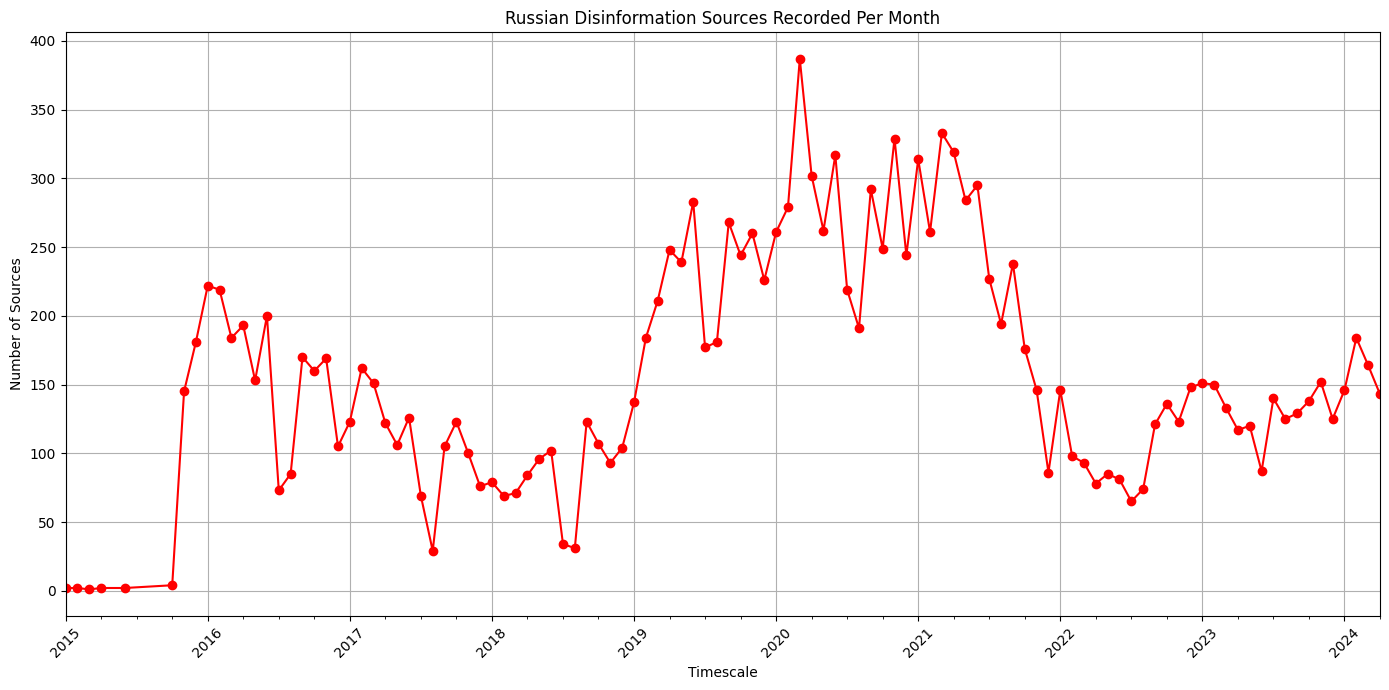

In [95]:
### Create a timescale graph of the Russian disinformation sources recorded ###
# Convert 'Date of publication' to datetime format and extract year and month for grouping
data['Date of publication'] = pd.to_datetime(data['Date of publication'], errors='coerce')
data['Year'] = data['Date of publication'].dt.year
data['Month'] = data['Date of publication'].dt.to_period('M')

# Count the number of entries per month
monthly_counts = data['Month'].value_counts().sort_index()

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))
monthly_counts.plot(kind='line', marker='o', linestyle='-', color='red', ax=ax)

plt.title('Russian Disinformation Sources Recorded Per Month')
plt.xlabel('Timescale')
plt.ylabel('Number of Sources')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

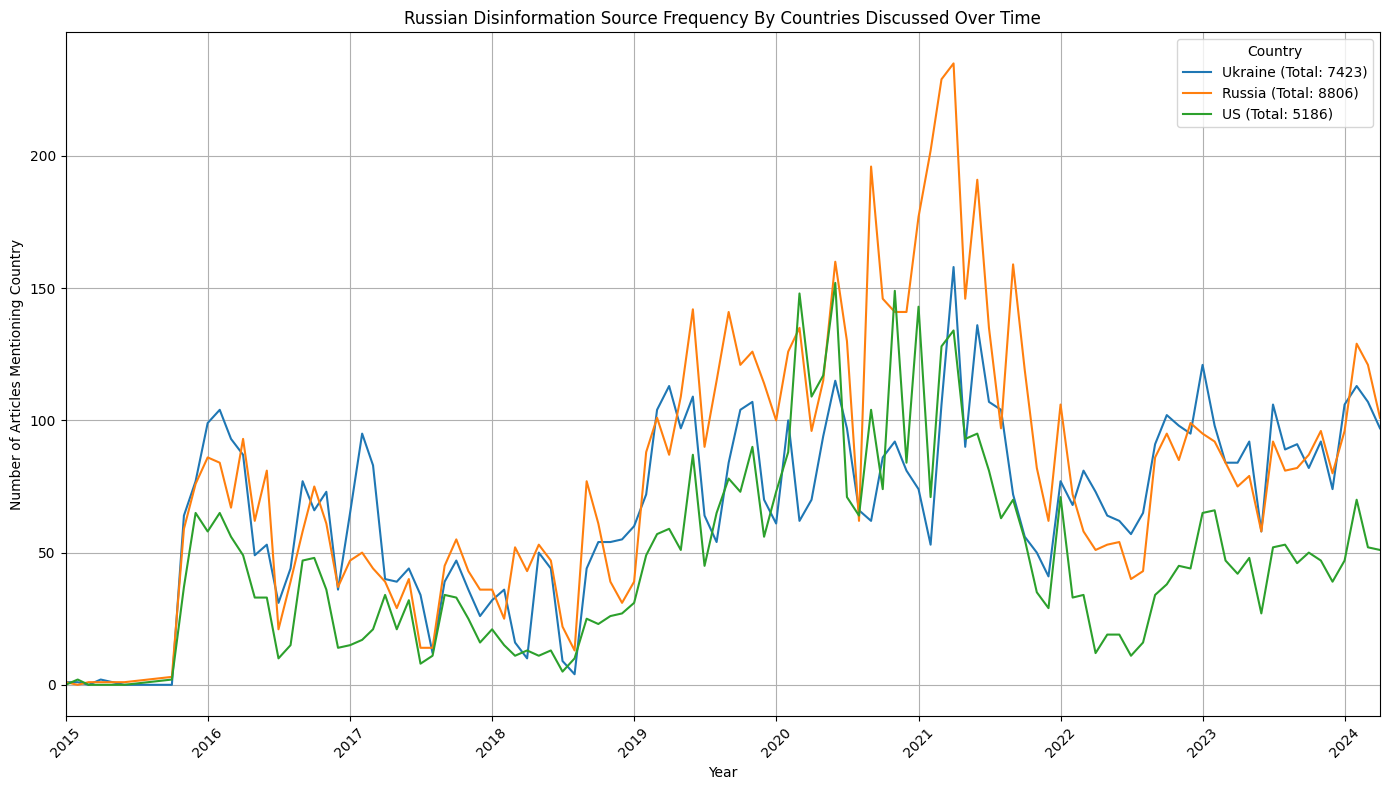

In [96]:
### Russian disinformation source frequency by countries top three countries discussed over time ###
# Convert the 'Date of publication' to datetime format
data['Date of publication'] = pd.to_datetime(data['Date of publication'], errors='coerce')

# exploded_data' approach
exploded_data = data[['Date of publication', 'Countries / regions discussed']].dropna().copy()
exploded_data['Countries / regions discussed'] = exploded_data['Countries / regions discussed'].str.split(',')
exploded_data = exploded_data.explode('Countries / regions discussed').reset_index(drop=True)
exploded_data['Countries / regions discussed'] = exploded_data['Countries / regions discussed'].str.strip()

# Publication dates to monthly periods
exploded_data['Month'] = exploded_data['Date of publication'].dt.to_period('M')

# Group by 'Month' and 'Countries / regions discussed'
grouped_data = exploded_data.groupby(['Month', 'Countries / regions discussed']).size().unstack(fill_value=0)

# Select top three countries
top_countries = ['Ukraine', 'Russia', 'US']
monthly_data_top_countries = grouped_data[top_countries]

# Convert the period index to timestamp for plotting
monthly_data_top_countries.index = monthly_data_top_countries.index.to_timestamp()

# Sum the total counts for Russia, Ukraine, and the US
total_counts = monthly_data_top_countries.sum()

# Plotting
plt.figure(figsize=(14, 8))
for country in top_countries:
    plt.plot(monthly_data_top_countries.index, monthly_data_top_countries[country], label=f"{country} (Total: {total_counts[country]})")

plt.title('Russian Disinformation Source Frequency By Countries Discussed Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Articles Mentioning Country')
plt.legend(title='Country')
plt.grid(True)
plt.xlim([monthly_data_top_countries.index.min(), monthly_data_top_countries.index.max()])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

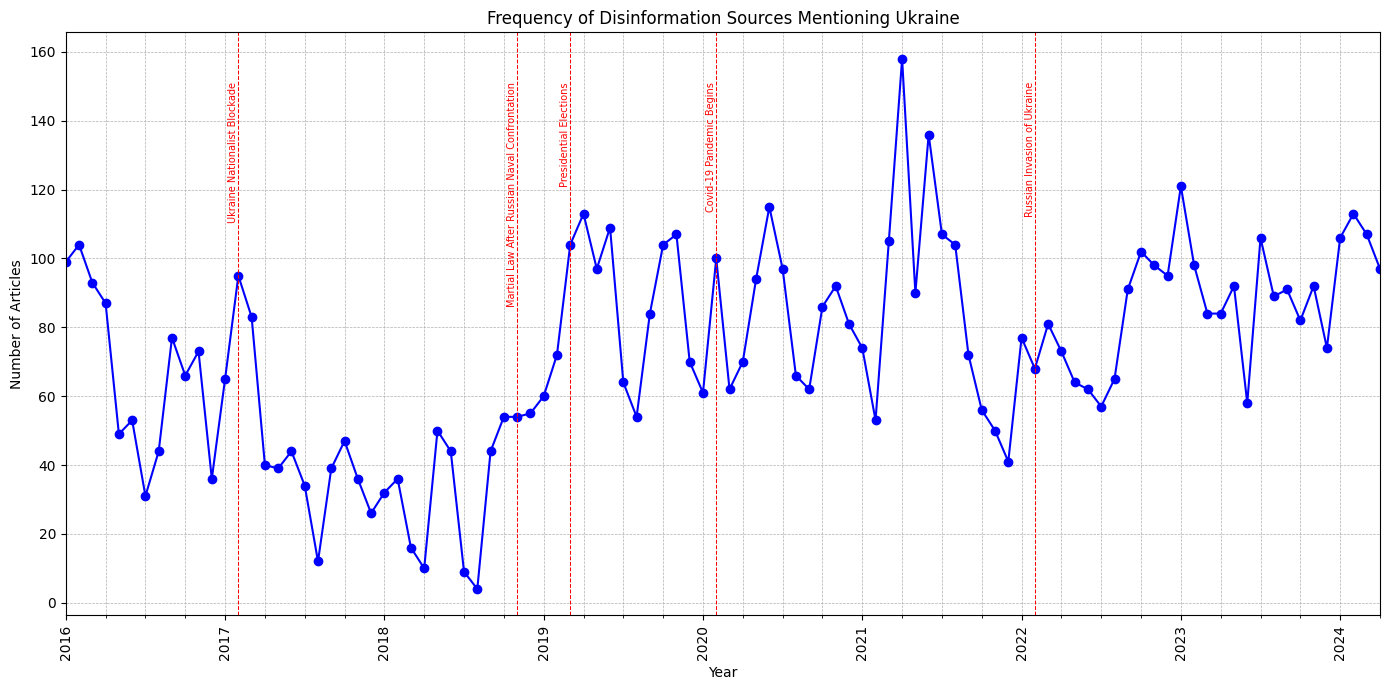

In [97]:
### Russian disinformation source frequency discussing ukraine with notable dates ###
data['Date of publication'] = pd.to_datetime(data['Date of publication'], errors='coerce')

# Drop rows where 'Date of publication' could not be converted
data = data.dropna(subset=['Date of publication'])

# Filter data to include only entries related to Ukraine
ukraine_data = data[data['Countries / regions discussed'].str.contains("Ukraine", na=False)]

# Further filter to include only data from 2016 onwards
ukraine_data = ukraine_data[(ukraine_data['Date of publication'].dt.year >= 2016) & (ukraine_data['Date of publication'].dt.year <= 2024)]

# Group data by month and year to see trends over time
monthly_counts = ukraine_data['Date of publication'].dt.to_period("M").value_counts().sort_index()

# Key events provided for annotation
key_events = [
    ('2017-02', 'Ukraine Nationalist Blockade'),
    ('2018-11', 'Martial Law After Russian Naval Confrontation'),
    ('2019-03', 'Presidential Elections'),
    ('2020-02', 'Covid-19 Pandemic Begins'),
    ('2022-02', 'Russian Invasion of Ukraine'),
]

# Plotting the data with annotations for key events
plt.figure(figsize=(14, 7))
monthly_counts.plot(kind='line', marker='o', color='blue')

# Annotate the key events
for date, event in key_events:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.75)  # Vertical line for the event
    plt.text(date, monthly_counts.max() * 0.95, event, rotation=90, verticalalignment='center_baseline', horizontalalignment='right', color='red', fontsize=7)

plt.title('Frequency of Disinformation Sources Mentioning Ukraine')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

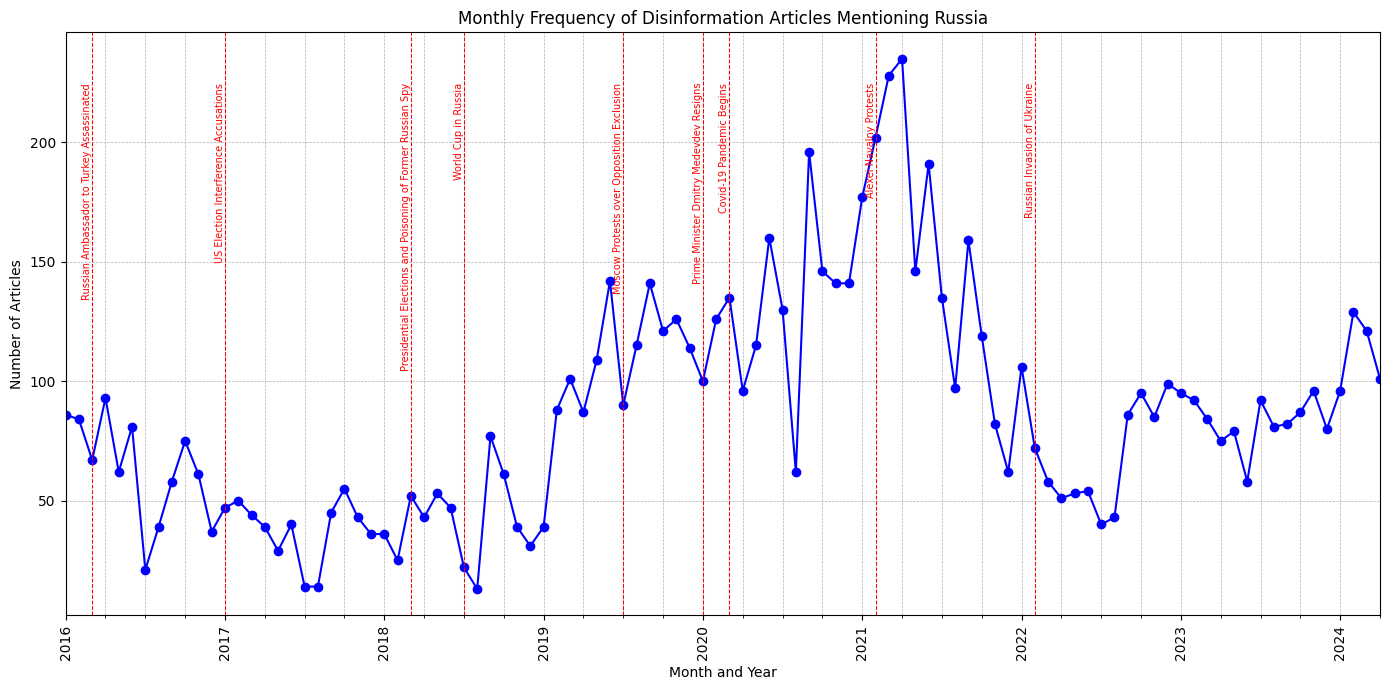

In [98]:
### Russian disinformation source frequency discussing russia with notable dates #####
data['Date of publication'] = pd.to_datetime(data['Date of publication'], errors='coerce')

data = data.dropna(subset=['Date of publication'])

russia_data = data[data['Countries / regions discussed'].str.contains("Russia", na=False)]
russia_data = russia_data[(russia_data['Date of publication'].dt.year >= 2016) & (russia_data['Date of publication'].dt.year <= 2024)]


monthly_counts = russia_data['Date of publication'].dt.to_period("M").value_counts().sort_index()

key_events = [
        ('2016-03', 'Russian Ambassador to Turkey Assassinated'),
        ('2017-01', 'US Election Interference Accusations'),
        ('2018-03', 'Presidential Elections and Poisoning of Former Russian Spy'),
        ('2018-07', 'World Cup in Russia'),
        ('2019-07', 'Moscow Protests over Opposition Exclusion'),
        ('2020-01', 'Prime Minister Dmitry Medevdev Resigns'),
        ('2020-03', 'Covid-19 Pandemic Begins'),
        ('2021-02', 'Alexei Navalny Protests'),
        ('2022-02', 'Russian Invasion of Ukraine'),
]

plt.figure(figsize=(14, 7))
monthly_counts.plot(kind='line', marker='o', color='blue')
for date, event in key_events:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.75)  # Vertical line for the event
    plt.text(date, monthly_counts.max() * 0.95, event, rotation=90, verticalalignment='center_baseline', horizontalalignment='right', color='red', fontsize=7)

plt.title('Monthly Frequency of Disinformation Articles Mentioning Russia')
plt.xlabel('Month and Year')
ax.set_xlim(pd.Timestamp('2016-01-01'), monthly_counts.index.max().to_timestamp())
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

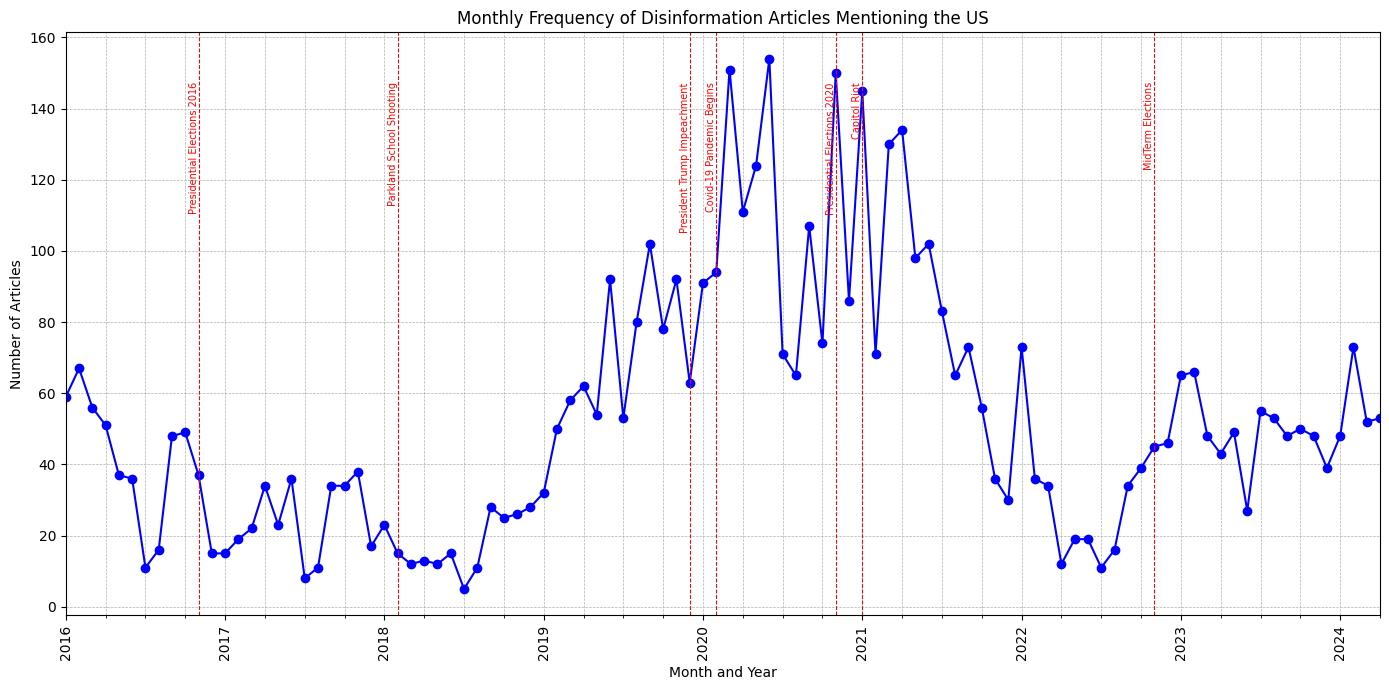

In [99]:
### Russian disinformation source frequency discussing US with notable dates ###
data['Date of publication'] = pd.to_datetime(data['Date of publication'], errors='coerce')

data = data.dropna(subset=['Date of publication'])

us_data = data[data['Countries / regions discussed'].str.contains("US", na=False)]
us_data = us_data[(us_data['Date of publication'].dt.year >= 2016) & (us_data['Date of publication'].dt.year <= 2024)]

monthly_counts = us_data['Date of publication'].dt.to_period("M").value_counts().sort_index()

key_events = [
        ('2016-11', 'Presidential Elections 2016'),
        ('2018-02', 'Parkland School Shooting'),
        ('2019-12', 'President Trump Impeachment'),
        ('2020-02', 'Covid-19 Pandemic Begins'),
        ('2020-11', 'Presidential Elections 2020'),
        ('2021-01', 'Capitol Riot'),
        ('2022-11', 'MidTerm Elections'),
]

plt.figure(figsize=(14, 7))
monthly_counts.plot(kind='line', marker='o', color='blue')

for date, event in key_events:
    plt.axvline(x=date, color='red', linestyle='--', linewidth=0.75)
    plt.text(date, monthly_counts.max() * 0.95, event, rotation=90, verticalalignment='center_baseline', horizontalalignment='right', color='red', fontsize=7)

plt.title('Monthly Frequency of Disinformation Articles Mentioning the US')
plt.xlabel('Month and Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=90)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

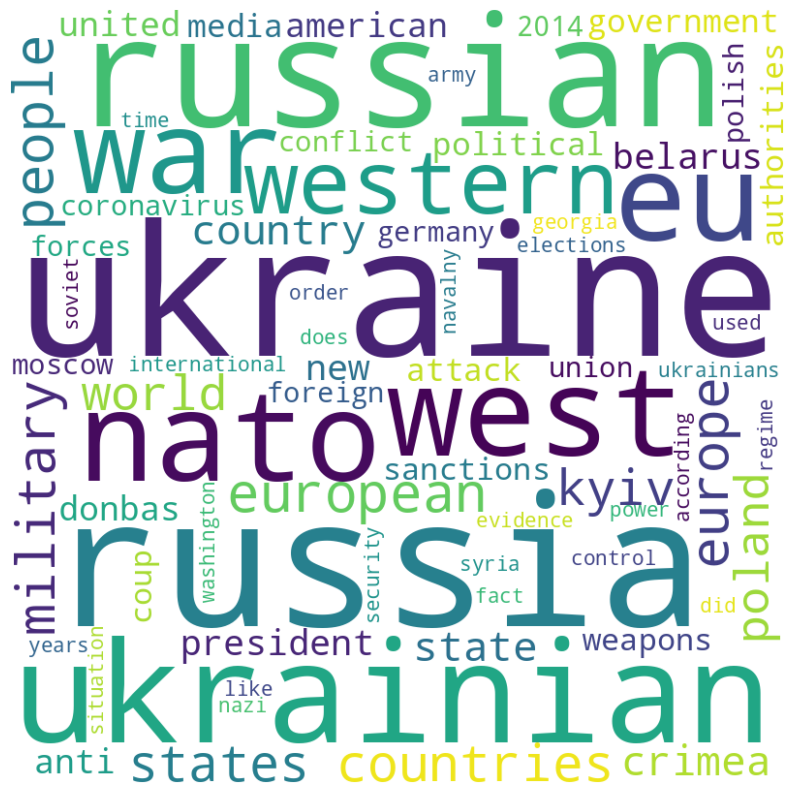

In [108]:
# Combine titles and summaries for keyword extraction
combined_texts = data['Title'] + " " + data['Summary']

# Assuming 'data' has 'Title' and 'Summary' columns already loaded
combined_texts = data['Title'] + " " + data['Summary']

# Initialising TF-IDF Vectorizer to extract top N words
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=5, max_features=100, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(combined_texts)

# Summing up the TF-IDF scores for each term across all items
sum_tfidf = np.sum(tfidf_matrix, axis=0)
words_freq = [(word, sum_tfidf[0, idx]) for word, idx in tfidf_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Limiting to the top 70 words
top_keywords = dict(words_freq[:70])

# Create a word cloud from the TF-IDF scores
wordcloud = WordCloud(width=800, height=800, background_color='white', random_state=1).generate_from_frequencies(top_keywords)

# Word cloud display
plt.figure(figsize=(10, 20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [109]:
# Combine titles and summaries
combined_texts = data['Title'] + " " + data['Summary']

# Load functions
nlp = spacy.load("en_core_web_sm")

# Function to extract entities and handle POS tagging
def extract_entities(texts):
    entities = []
    for doc in nlp.pipe(texts):  # removed disable to use tagger and other components
        entities.extend([(X.text, X.label_) for X in doc.ents])
    return entities

# Extract entities from combined texts
entities = extract_entities(combined_texts)

# Count frequency of each entity
entity_freq = Counter(entities)
most_common_entities = entity_freq.most_common(50)  # Get the top 50 entities

# Display the most common entities and their frequencies
print("Most common entities and their frequencies:")
for entity, freq in most_common_entities:
    print(f"{entity[0]} ({entity[1]}): {freq}")

# Display example text
sample_text = combined_texts.iloc[0]
doc = nlp(sample_text)
displacy.render(doc, style='ent', jupyter=True)

Most common entities and their frequencies:
Russia (GPE): 11952
Ukraine (GPE): 9766
US (GPE): 6415
Russian (NORP): 5228
Ukrainian (NORP): 3549
NATO (ORG): 3519
EU (ORG): 3336
West (LOC): 2954
Poland (GPE): 2301
Europe (LOC): 2037
Belarus (GPE): 1551
European (NORP): 1339
American (NORP): 1269
Polish (NORP): 1237
Donbas (GPE): 1147
Moscow (GPE): 1120
Germany (GPE): 1034
Washington (GPE): 933
the United States (GPE): 893
Syria (GPE): 882
anti-Russian (NORP): 857
Georgia (GPE): 832
Ukrainians (NORP): 827
2014 (DATE): 799
Western (NORP): 780
Ukrainian (GPE): 738
Belarusian (NORP): 716
Lithuania (GPE): 715
Crimea (GPE): 672
Russians (NORP): 655
China (GPE): 651
German (NORP): 646
UK (GPE): 617
France (GPE): 603
Baltic (NORP): 603
Americans (NORP): 585
first (ORDINAL): 578
Crimea (ORG): 575
USA (GPE): 572
one (CARDINAL): 572
Nazi (NORP): 568
British (NORP): 539
Kyiv (PERSON): 515
Minsk (GPE): 503
the European Union (ORG): 493
Navalny (PERSON): 493
USSR (GPE): 491
two (CARDINAL): 477
Putin (P

In [110]:
 # Create counters for each category of interest
date_entities = Counter()
gpe_entities = Counter()
norp_entities = Counter()
person_entities = Counter()
org_entities = Counter()
event_entities = Counter()

# Filter and count entities by their type
for entity, label in entities:
    if label == 'DATE':
        date_entities[entity] += 1
    elif label == 'GPE':
        gpe_entities[entity] += 1
    elif label == 'NORP':
        norp_entities[entity] += 1
    elif label == 'PERSON':
        person_entities[entity] += 1
    elif label == 'ORG':
      org_entities[entity] += 1
    elif label == 'EVENT':
      event_entities[entity] += 1

# Display the most common entities in each category
print("Most common DATE entities and their frequencies:")
for entity, freq in date_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

print("\nMost common GPE entities and their frequencies:")
for entity, freq in gpe_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

print("\nMost common NORP entities and their frequencies:")
for entity, freq in norp_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

print("\nMost common PERSON entities and their frequencies:")
for entity, freq in  person_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

print("\nMost common ORG entities and their frequencies:")
for entity, freq in  org_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

print("\nMost common EVENT entities and their frequencies:")
for entity, freq in  event_entities.most_common(10):  # Display top 10
    print(f"{entity}: {freq}")

Most common DATE entities and their frequencies:
2014: 799
today: 321
Today: 200
2020: 140
Week: 118
2016: 116
years: 104
2018: 98
March 2014: 88
February 2014: 70

Most common GPE entities and their frequencies:
Russia: 11952
Ukraine: 9766
US: 6415
Poland: 2301
Belarus: 1551
Donbas: 1147
Moscow: 1120
Germany: 1034
Washington: 933
the United States: 893

Most common NORP entities and their frequencies:
Russian: 5228
Ukrainian: 3549
European: 1339
American: 1269
Polish: 1237
anti-Russian: 857
Ukrainians: 827
Western: 780
Belarusian: 716
Russians: 655

Most common PERSON entities and their frequencies:
Kyiv: 515
Navalny: 493
Putin: 441
Maidan: 306
Crimea: 287
Biden: 263
Hitler: 238
Donbas: 214
Vladimir Putin: 211
Soros: 209

Most common ORG entities and their frequencies:
NATO: 3519
EU: 3336
Crimea: 575
the European Union: 493
CIA: 339
Belarus: 301
Trump: 296
ISIS: 295
COVID-19: 278
UN: 261

Most common EVENT entities and their frequencies:
WWII: 244
World War II: 128
the Cold War: 79
th